In [46]:
import os
import cv2
import shutil
import numpy as np
from glob import glob
from pathlib import Path
import matplotlib.pyplot  as plt
import sys
sys.path.append("../")

In [18]:
def load_yolo_labels(label_path, img_shape):
    """
    Load YOLO labels from a file and convert them to pixel coordinates.

    Inputs:
        - `label_path`: Path to the label file | type: str
        - `img_shape`: Shape of the image (height, width) | type: tuple
    Output(s):
        - List of labels in pixel coordinates | type: list
    """
    with open(label_path, "r") as f:
        lines = f.readlines()
    
    for i in range(len(lines)):
        # Convert string to numpy array and reshape
        lines[i] = np.array([float(j) for j in lines[i].replace("\n","").split()[1:]]).reshape((-1,2))
        # Convert normalized coordinates to pixel coordinates
        lines[i][:, 0] *= img_shape[1]
        lines[i][:, 1] *= img_shape[0]
        # Convert to integer
        lines[i] = lines[i].astype(np.int32)
    return lines

In [87]:
split = "train"
root = Path(f"../TRAIN_DATA/Words_2/{split}")
dest =  Path(f"../TRAIN_DATA/Words_2_box/{split}")

os.makedirs(dest, exist_ok=True)
(dest/"images").mkdir(exist_ok=True)
(dest/"labels").mkdir(exist_ok=True)

In [88]:
image_paths = glob(os.path.join(root, "images/*"))
label_paths = [str(i).replace("images", "labels").replace(".jpeg", ".txt").replace(".jpg", ".txt") for i in image_paths]

In [89]:
def get_box_from_poly(poly, img_shape):
    xmin, ymin = poly.min(axis=0)
    xmax,  ymax = poly.max(axis=0)
    
    xc = (xmin+xmax)/2 / img_shape[1]
    yc = (ymin+ymax)/2 / img_shape[0]
    w = (xmax-xmin) / img_shape[1]
    h = (ymax-ymin) / img_shape[0]
    
    return xc,yc,w,h

In [90]:
cls = 0
for i,label_path in enumerate(label_paths):
    img = cv2.imread(image_paths[i])
    polygons = load_yolo_labels(label_path, img.shape)
    
    label = ""
    for poly in polygons:
        box = get_box_from_poly(poly, img.shape)
        label += f"{cls} {box[0]} {box[1]} {box[2]} {box[3]}\n"
        
    with open(dest/"labels"/Path(label_path).name, "w") as f:
        f.write(label)
    
    shutil.copy2(image_paths[i], dest/"images"/Path(image_paths[i]).name)

In [99]:
import numpy as np
from matplotlib.path import Path

# Create a black image of shape (500, 500)
image = np.zeros((500, 500), dtype=np.uint16)

# Create a polygon represented by a (4, 2) array of its vertices' coordinates
polygon = np.array([[100, 100], [200, 150], [150, 150], [200, 200], [100, 200]])
# Create a Path object for the polygon
path = Path(polygon)

# Create a grid of points representing the pixel coordinates
x, y = np.meshgrid(np.arange(500), np.arange(500))
points = np.column_stack((x.ravel(), y.ravel()))

# Create a binary mask for the polygon
mask = path.contains_points(points).reshape(500, 500) 

# Set the value of the pixels inside the polygon to 255
image[mask] = 1000

(5, 2)


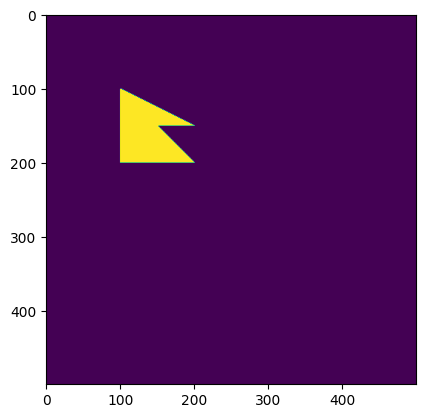

In [98]:
plt.imshow(image)